# COMP - 4301 Final Project - Path Detection using Object Detection in Video/Images
## Authors:
- Yaksh J Haranwala (201907532)
- Abdul Shaji
- Salman Haidri (2019065620 ?correct if wrong)
- Mohammed Shoaib (201952389)

## Beginning Notes:
- At the moment, I am planning to use this notebook as a centralized code file, since it is easier to code and debug in jupyter notebooks.
- As each of the below described code chunks get completed, the plan is to move them to separate .py modules as we go.
- This will allow for better, modular and understandable code.
- Finally, we will create a runner file that orchestrates the running of the entire module.
- Download the weights from: https://s3.amazonaws.com/amdegroot-models/ssd300_mAP_77.43_v2.pth

## File Descriptions:
- Object Detection (To be put in a separate .py file):
    - Using the PyTorch/Tensorflow framework, evaluate multiple pre-trained networks we have.
    - Choose the best one (fastest and with much higher prediction accuracy) to use as the model.
    - I think this is the right place to draw bounding boxes as well (if we want to).
    - Reference: https://github.com/amdegroot/ssd.pytorch
    - Furthermore, the loading of data, weights and training data is also taken from the same repo.

- Video Input Module (To be put in a separate .py file):
    - Currently, we are starting with image object detection.
    - However, I am planning it to expand it to live video feed either captured from webcam or by connecting a mobile device to the laptop (there must be some examples available).
    - This module will capture the video feed and send it to the object detection module to analyze.

- Distance calculation module (To be put in a separate .py file):
    - This module will be used to calculate the distance between 2 objects in the image/video to make sure that the guided object can pass between them without any issues.
    - We will simplify this by considering the object to be guided in our project to be a rectangle to make the calculation easier.
    - Reference: https://heartbeat.comet.ml/social-distance-detector-with-python-yolov4-darknet-and-opencv-62e66c15c2a4

- Runner Module (To be put in a separate .py file):
    - This is the conductor file which performs error handling and stuff to make sure that the program, if crashes then it does so gracefully.

### A few notes:
- Document the code as much as possible.
- PLEASE get a citation of the code if you got even a chunk of it from somewhere and put it in the comments with the associated code.

In [1]:
import warnings

import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import imutils
import torch
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

from ssd.ssd import build_ssd
from ssd.data.__init__ import BaseTransform

from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours


warnings.simplefilter("ignore", category=UserWarning)

In [2]:
net = build_ssd('test')
net.load_weights('./ssd300_mAP_77.43_v2.pth')
net.load_state_dict(torch.load('./ssd300_mAP_77.43_v2.pth'))
transform = BaseTransform(net.size, (104/256.0, 117/256.0, 123/256.0))

Loading weights into state dict...
Finished!


In [3]:
COLORS = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]

def detect_objects(frame):
    """
        Given the current frame in the video, detect all the objects that
        the neural net can.

        Parameters
        ----------
            frame: np.ndarray
                The current video frame

        Returns
        -------
            frame: np.ndarray
                The current video frame with bbox drawn around detected objects.
    """
    height, width = frame.shape[:2]
    x = torch.from_numpy(transform(frame)[0]).permute(2, 0, 1)
    if torch.cuda.is_available():
        x = x.cuda()
    x = x.unsqueeze(0)
    y = net(x)  # forward pass
    detections = y.data
    # scale each detection back up to the image
    scale = torch.Tensor([width, height, width, height])
    bboxes = []
    for i in range(detections.size(1)):
        j = 0
        while detections[0, i, j, 0] >= 0.1:
            pt = (detections[0, i, j, 1:] * scale).cpu().numpy()
            if (len(pt)) > 0:
                t_l = pt[0], pt[1]
                t_r = pt[2], pt[1]
                b_l = pt[0], pt[3]
                b_r = pt[2], pt[3]
                bboxes.append(np.array([t_l, t_r, b_r, b_l], dtype=np.int32))
            cv.rectangle(frame,
                          (int(pt[0]), int(pt[1])),
                          (int(pt[2]), int(pt[3])),
                          COLORS[i % 3], 2)

            j += 1
    return frame, bboxes

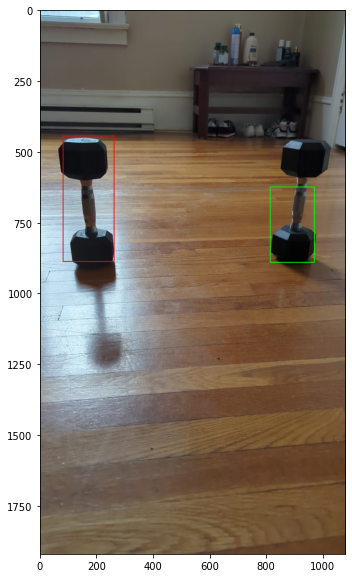

In [7]:
image = cv.imread('./test_img/bells.jpg')
rgb_image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))

frame, bboxes = detect_objects(rgb_image)
plt.imshow(frame)
plt.show()

In [8]:
# Note: This may or may not be needed based on what we end up deciding.

def midpoint(ptA, ptB):
	return (ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5

def calculate_distances(image, bboxes, guided_object_width):
    colors = ((0, 0, 255), (240, 0, 159), (0, 165, 255), (255, 255, 0),
        (255, 0, 255))

    # loop over the contours individually
    for box in bboxes:
        # compute the center of the bounding box
        cX = np.average(box[:, 0])
        cY = np.average(box[:, 1])

        # Now we need to set a bounding box as a reference bounding box.
        # So we take the first bounding box as the reference bounding box
        # and then the distances are calculated accordingly.
        if refObj is None:
            # unpack the ordered bounding box, then compute the
            # midpoint between the top-left and top-right points,
            # followed by the midpoint between the top-right and
            # bottom-right
            (tl, tr, br, bl) = box
            (tlblX, tlblY) = midpoint(tl, bl)
            (trbrX, trbrY) = midpoint(tr, br)
            # compute the Euclidean distance between the midpoints,
            # then construct the reference object
            D = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
            refObj = (box, (cX, cY), D / guided_object_width)
            continue

        # draw the contours on the image
        orig = image.copy()
        cv.rectangle(orig, box[0], box[2], (255, 0, 0), 2)
        cv.rectangle(orig, refObj[0][0], refObj[0][2], (255, 0, 0), 2)

        # stack the reference coordinates and the object coordinates
        # to include the object center
        refCoords = np.vstack([refObj[0], (refObj[1][0], refObj[1][1])])
        objCoords = np.vstack([box, (cX, cY)])

    # loop over the original points
    for ((xA, yA), (xB, yB), color) in zip(refCoords, objCoords, colors):
        # draw circles corresponding to the current points and
        # connect them with a line
        cv.circle(orig, (int(xA), int(yA)), 5, color, -1)
        cv.circle(orig, (int(xB), int(yB)), 5, color, -1)
        cv.line(orig, (int(xA), int(yA)), (int(xB), int(yB)),
            color, 2)
        # compute the Euclidean distance between the coordinates,
        # and then convert the distance in pixels to distance in
        # units
        D = dist.euclidean((xA, yA), (xB, yB)) / refObj[2]
        (mX, mY) = midpoint((xA, yA), (xB, yB))
        cv.putText(orig, "{:.1f}in".format(D), (int(mX), int(mY - 10)),
            cv.FONT_HERSHEY_SIMPLEX, 0.55, color, 2)

    # show the output image
    cv.imshow("Image", orig)
    if cv.waitKey(0) == ord('q'):
        cv.destroyAllWindows()

In [10]:
calculate_distances(image, bboxes, 10)